## EDA valeurs nutritionnelles


# Analyse exploratoire des valeurs nutritionnelles — Projet Mangetamain

## Objectif

Ce notebook vise à explorer et analyser les **valeurs nutritionnelles** des recettes issues du dataset *Food.com*.
L’objectif est de comprendre la répartition des principaux nutriments (protéines, lipides, glucides, calories, etc.)
et d’identifier d’éventuelles structures ou corrélations entre ces variables.

## Données utilisées

Les données proviennent du dataset Kaggle :  
[Food.com Recipes and Interactions](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions)



In [4]:
#modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast 
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer


In [5]:
data_path = "../data/RAW_recipes.csv"

# charger les colonnes "utiles"
cols = ["name", "id", "minutes", "n_steps", "n_ingredients", "nutrition"]
df = pd.read_csv(data_path, usecols=cols, nrows=20000) 

print(f"Données chargées : {df.shape[0]} lignes, {df.shape[1]} colonnes")



Données chargées : 20000 lignes, 6 colonnes


In [6]:
df.head(10)

,name,id,minutes,nutrition,n_steps,n_ingredients
0,arriba baked winter squash mexican style,137739,55,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,7
1,a bit different breakfast pizza,31490,30,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,6
2,all in the kitchen chili,112140,130,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,13
3,alouette potatoes,59389,45,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,11
4,amish tomato ketchup for canning,44061,190,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,8
5,apple a day milk shake,5289,0,"[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,4
6,aww marinated olives,25274,15,"[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,9
7,backyard style barbecued ribs,67888,120,"[1109.5, 83.0, 378.0, 275.0, 96.0, 86.0, 36.0]",10,22
8,bananas 4 ice cream pie,70971,180,"[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,6
9,beat this banana bread,75452,70,"[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,9


In [7]:
# extraction de donneés

def extract_nutrition_values(row):
    try:
        values = ast.literal_eval(row)
        if isinstance(values, list) and len(values) == 7:
            return pd.Series(values)
        else:
            return pd.Series([np.nan]*7)
    except:
        return pd.Series([np.nan]*7)

df_nutrition = df["nutrition"].apply(extract_nutrition_values)
df_nutrition.columns = ["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]

df = pd.concat([df.drop(columns=["nutrition"]), df_nutrition], axis=1)

df = df.astype({
    "calories": float, "fat": float, "sugar": float, "sodium": float,
    "protein": float, "sat_fat": float, "carbs": float
})

print("Colonnes nutritionnelles")



Colonnes nutritionnelles


In [8]:
df.head(10)

,name,id,minutes,n_steps,n_ingredients,calories,fat,sugar,sodium,protein,sat_fat,carbs
0,arriba baked winter squash mexican style,137739,55,11,7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,9,6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,6,13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,11,11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,5,8,352.9,1.0,337.0,23.0,3.0,0.0,28.0
5,apple a day milk shake,5289,0,4,4,160.2,10.0,55.0,3.0,9.0,20.0,7.0
6,aww marinated olives,25274,15,4,9,380.7,53.0,7.0,24.0,6.0,24.0,6.0
7,backyard style barbecued ribs,67888,120,10,22,1109.5,83.0,378.0,275.0,96.0,86.0,36.0
8,bananas 4 ice cream pie,70971,180,8,6,4270.8,254.0,1306.0,111.0,127.0,431.0,220.0
9,beat this banana bread,75452,70,12,9,2669.3,160.0,976.0,107.0,62.0,310.0,138.0


## Analyse descriptive des valeurs nutritionnelles

Objectif => première compréhension statistique des principales variables nutritionnelles
(calories, lipides, sucres, sodium, protéines, graisses saturées et glucides).

Cela se composera de:
- Un calcul des statistiques descriptives (moyenne, médiane, min, max, écart-type, etc.)
- Une visualisation des profils dominants.
- Une identification des valeurs extrêmes ( qui pourraient fausser l'analyse)


In [9]:
stats = df[["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]].describe().T
stats["median"] = df[["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]].median()
stats["missing_values (%)"] = df[["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]].isna().mean() * 100

# Tri
stats = stats[["count", "mean", "std", "min", "25%", "median", "75%", "max", "missing_values (%)"]]
stats.round(2)


,count,mean,std,min,25%,median,75%,max,missing_values (%)
calories,20000.0,481.72,734.30,0.0,177.8,314.9,519.2,21497.8,0.0
fat,20000.0,36.49,67.82,0.0,8.0,21.0,41.0,2770.0,0.0
sugar,20000.0,91.12,280.95,0.0,10.0,28.0,81.0,12914.0,0.0
sodium,20000.0,30.49,143.50,0.0,5.0,14.0,32.0,14152.0,0.0
protein,20000.0,33.70,63.11,0.0,6.0,17.0,48.0,3605.0,0.0
sat_fat,20000.0,45.31,90.00,0.0,7.0,22.0,52.0,2731.0,0.0
carbs,20000.0,16.26,32.53,0.0,4.0,9.0,17.0,1098.0,0.0


<Figure size 1400x800 with 0 Axes>

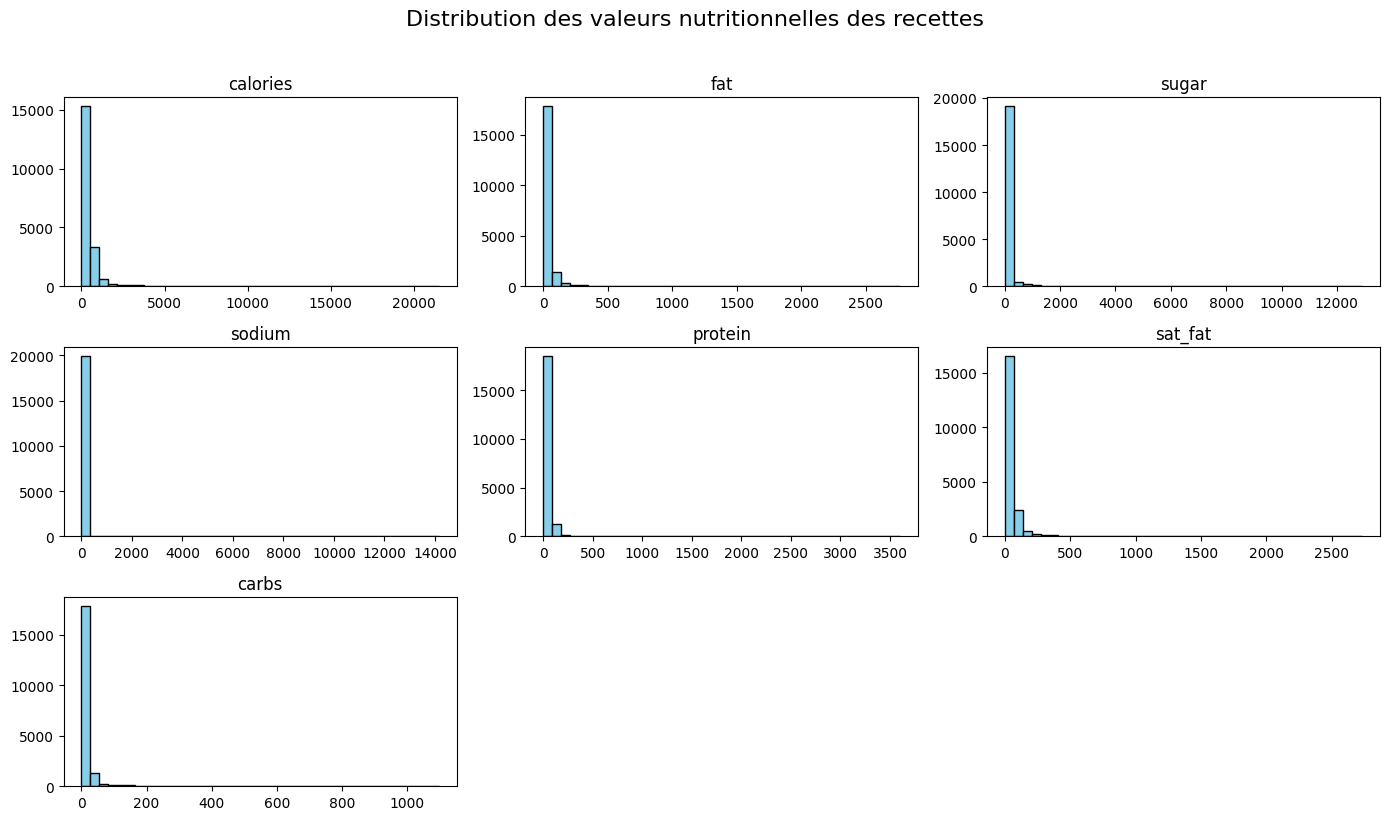

In [10]:
# Tracé histogramme
plt.figure(figsize=(14, 8))
df[["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]].hist(
    bins=40, figsize=(14, 8), color="skyblue", edgecolor="black", grid=False
)
plt.suptitle("Distribution des valeurs nutritionnelles des recettes", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [11]:
# résumé de tout ca
summary = df[["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]].agg(["mean", "std", "median"]).T
summary = summary.rename(columns={"mean": "Moyenne", "std": "Écart-type", "median": "Médiane"})
summary.round(2)


,Moyenne,Écart-type,Médiane
calories,481.72,734.30,314.9
fat,36.49,67.82,21.0
sugar,91.12,280.95,28.0
sodium,30.49,143.50,14.0
protein,33.70,63.11,17.0
sat_fat,45.31,90.00,22.0
carbs,16.26,32.53,9.0


## Analyse de corrélation entre les variables nutritionnelles

Etude des relations linéaires entre les différentes composantes nutritionnelles.  
Remarquer : certaines variables sont souvent interdépendantes —> par exemple, les recettes riches en calories sont souvent riches en lipides et en glucides.


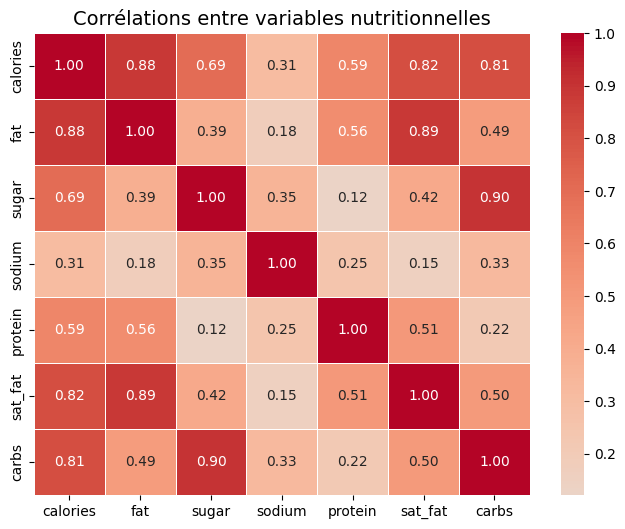

In [12]:
#correlation matrice
corr = df[["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Corrélations entre variables nutritionnelles", fontsize=14)
plt.show()


### Interprétation

- Les **calories** sont fortement corrélées aux **lipides** et aux **glucides**
- Les **graisses saturées (sat_fat)** suivent la même tendance que les **lipides totaux**.  
- La **protéine** est moins corrélée aux calories, indiquant que certains plats riches en protéines ne sont pas nécessairement caloriques (ex : plats à base de poisson ou œufs).  
- Le **sodium** montre souvent une corrélation faible ou négative avec les autres variables, ce qui reflète une forte variabilité selon le type de plat (desserts vs plats salés).


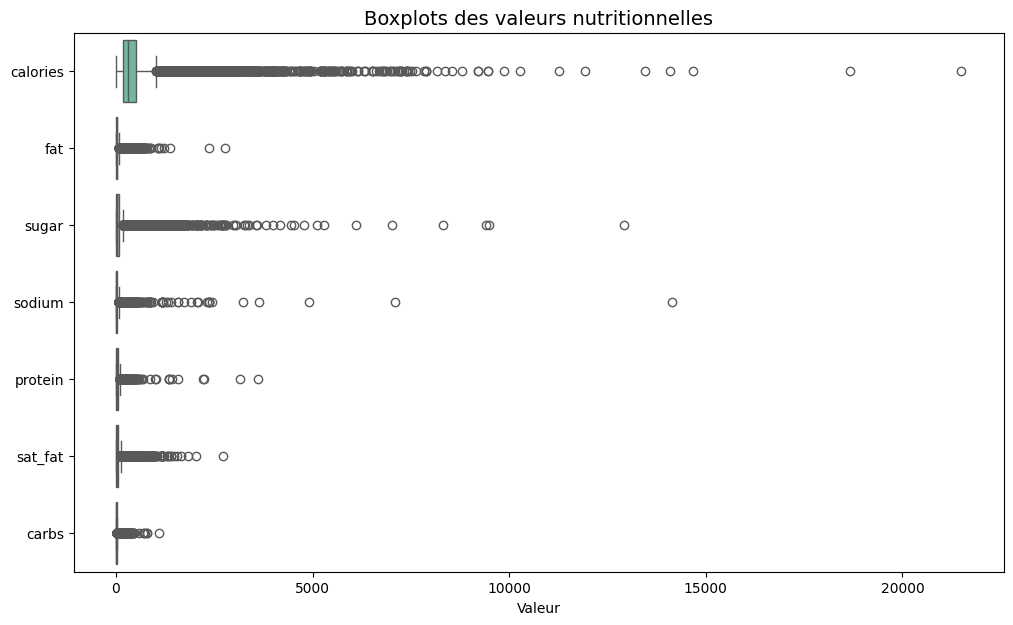

In [13]:
# boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(data=df[["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]], orient="h", palette="Set2")
plt.title("Boxplots des valeurs nutritionnelles", fontsize=14)
plt.xlabel("Valeur")
plt.show()


In [14]:
# interquartile range
outlier_summary = {}

for col in ["calories", "fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_pct = 100 * outlier_count / len(df)
    outlier_summary[col] = [outlier_count, round(outlier_pct, 2)]

outlier_df = pd.DataFrame(outlier_summary, index=["Nb_outliers", "Pct_outliers (%)"]).T
outlier_df.sort_values(by="Pct_outliers (%)", ascending=False)


,Nb_outliers,Pct_outliers (%)
sugar,1856.0,9.28
sodium,1522.0,7.61
calories,1440.0,7.20
fat,1406.0,7.03
sat_fat,1391.0,6.96
carbs,1323.0,6.62
protein,883.0,4.42


 # Clustering
 
 Objectif : 
- regrouper des plats similaires (plats “sains” vs “riches”),
- détecter des profils typologiques (desserts sucrés, plats salés, recettes équilibrées, etc.),

In [15]:
# preprocessing
cols = ["calories","fat","sugar","sodium","protein","sat_fat","carbs"]
df_work = df_nutrition.dropna(subset=cols).copy()

#log1p pour minimiser les outliers , avant j'avais un cluster "fourre-tout" avec 90% des recettes
X_log = np.log1p(df_work[cols].values)

robust_scaler = RobustScaler()
X_scaled = robust_scaler.fit_transform(X_log)

X_index = df_work.index



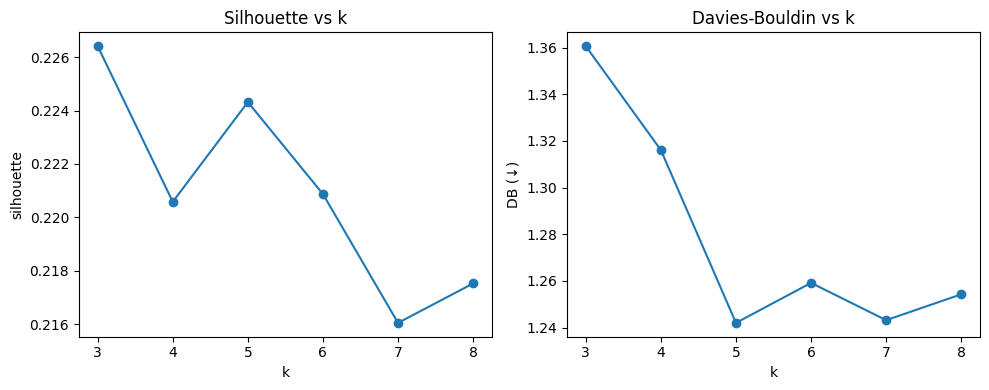

3

In [16]:
ks = range(3, 9)
silh, db = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    silh.append(silhouette_score(X_scaled, labels))
    db.append(davies_bouldin_score(X_scaled, labels))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(list(ks), silh, marker='o'); ax[0].set_title("Silhouette vs k"); ax[0].set_xlabel("k"); ax[0].set_ylabel("silhouette")
ax[1].plot(list(ks), db, marker='o');   ax[1].set_title("Davies-Bouldin vs k"); ax[1].set_xlabel("k"); ax[1].set_ylabel("DB (↓)")
plt.tight_layout(); plt.show()

best_k = ks[int(np.argmax(silh))]
best_k


Selon wikipédia, "Davies-bouldin": C'est la moyenne du rapport maximal entre la distance d'un point au centre de son groupe et la distance entre deux centres de groupes.

In [17]:
# kmeans
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_work["cluster"] = labels
df_nutrition.loc[X_index, "cluster"] = labels 

print(df_work["cluster"].value_counts().sort_index())
print((df_work["cluster"].value_counts(normalize=True)*100).sort_index().round(2))




cluster
0     5022
1     4924
2    10054
Name: count, dtype: int64
cluster
0    25.11
1    24.62
2    50.27
Name: proportion, dtype: float64


petit probleme de cluster ici on a un cluster singleton ( le 0) qui regroupe 90% des recettes


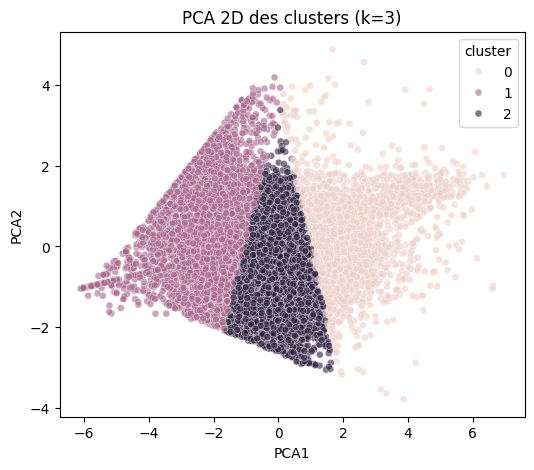

In [18]:
# PCA pour visualisation
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_work["PCA1"], df_work["PCA2"] = X_pca[:,0], X_pca[:,1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_work, x="PCA1", y="PCA2", hue="cluster", s=25, alpha=0.6)
plt.title(f"PCA 2D des clusters (k={best_k})")
plt.show()


In [19]:
# profiles par clusters
cluster_meds = df_work.groupby("cluster")[cols].median().round(2)
cluster_meds



,calories,fat,sugar,sodium,protein,sat_fat,carbs
cluster,,,,,,,
0,729.15,57.0,79.0,40.0,54.0,74.0,22.0
1,109.35,3.0,22.0,2.0,3.5,2.0,5.0
2,306.10,21.0,20.0,14.5,19.0,24.0,8.0


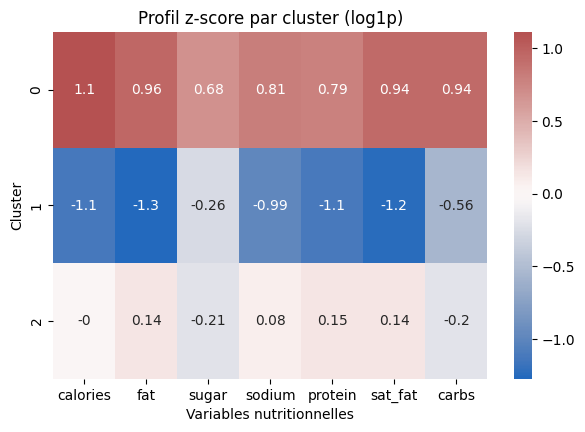

In [20]:
# heatmap par cluster
global_mean = X_log.mean(axis=0)
global_std  = X_log.std(axis=0, ddof=0)

centroids_scaled = kmeans.cluster_centers_
centroids_log = robust_scaler.inverse_transform(centroids_scaled) 
centroids_z = (centroids_log - global_mean) / global_std

z_df = pd.DataFrame(centroids_z, columns=cols).round(2)
plt.figure(figsize=(7, 0.5*best_k + 3))
sns.heatmap(z_df, annot=True, cmap="vlag", center=0)
plt.title("Profil z-score par cluster (log1p)")
plt.xlabel("Variables nutritionnelles"); plt.ylabel("Cluster")
plt.show()



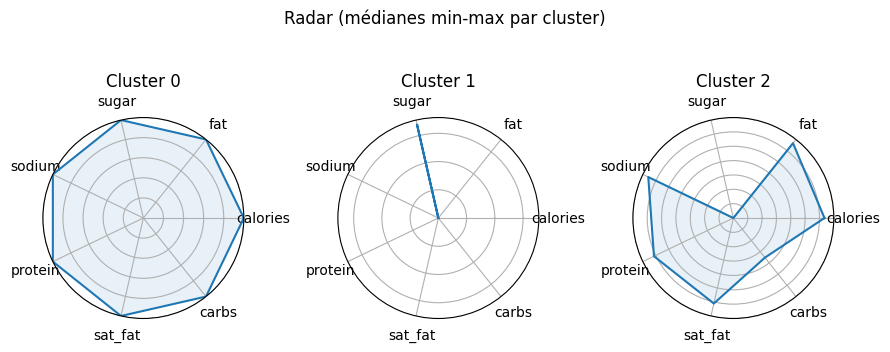

In [21]:
# radar par clusters
def plot_radar(df_centers, title="Radar par cluster"):
    vars_ = df_centers.columns.tolist()
    angles = np.linspace(0, 2*np.pi, len(vars_), endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(min(12, 3*len(df_centers)), 4))
    for i, (cid, row) in enumerate(df_centers.iterrows(), 1):
        values = row.values.tolist()
        values += values[:1]
        ax = plt.subplot(1, len(df_centers), i, polar=True)
        ax.plot(angles, values); ax.fill(angles, values, alpha=0.1)
        ax.set_title(f"Cluster {cid}")
        ax.set_xticks(angles[:-1]); ax.set_xticklabels(vars_)
        ax.set_yticklabels([])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

meds_minmax = (cluster_meds - cluster_meds.min())/(cluster_meds.max()-cluster_meds.min() + 1e-9)
plot_radar(meds_minmax, "Radar (médianes min-max par cluster)")


In [22]:
# labels autos
tmp = meds_minmax.copy()
tmp["index_sucre"]     = tmp["sugar"] + tmp["carbs"]
tmp["index_lipides"]   = tmp["fat"] + tmp["sat_fat"]
tmp["index_sodium"]    = tmp["sodium"]
tmp["index_proteines"] = tmp["protein"]

labels_map = {}
for cid, row in tmp.iterrows():
    ranks = row[["index_sucre","index_lipides","index_sodium","index_proteines"]] \
              .sort_values(ascending=False).index.tolist()
    top = ranks[:2]
    if "index_sucre" in top and "index_lipides" in top:
        label = "Desserts sucrés / riches"
    elif "index_lipides" in top and "index_sodium" in top:
        label = "Gras-salé"
    elif "index_proteines" in top and "index_lipides" not in top and "index_sucre" not in top:
        label = "Protéiné / équilibré"
    elif row[["index_sucre","index_lipides","index_sodium"]].max() < 0.4:
        label = "Léger / low-cal"
    else:
        label = "Mix équilibré"
    labels_map[cid] = label

labels_map
df_work["cluster_label"] = df_work["cluster"].map(labels_map)
df_nutrition.loc[X_index, "cluster_label"] = df_work["cluster_label"]
df_work[["cluster","cluster_label"]].drop_duplicates().sort_values("cluster")


,cluster,cluster_label
7,0,Desserts sucrés / riches
0,1,Desserts sucrés / riches
1,2,Gras-salé


In [23]:
# Recap globale de tout ce qui a été fait
print("=== Sanity check des clusters ===")

print("\n Indices sucre / lipides / sodium / protéines :")
display(tmp[["index_sucre","index_lipides","index_sodium","index_proteines"]].round(2))

print("\n Classement des indices (décroissant) :")
for cid, row in tmp.iterrows():
    ranks = row[["index_sucre","index_lipides","index_sodium","index_proteines"]] \
               .sort_values(ascending=False)
    print(f"\nCluster {cid} ({labels_map.get(cid,'')})")
    print(ranks)

print("\n Médianes nutritionnelles par cluster (vs global) :")
cluster_meds_raw = df_work.groupby("cluster")[cols].median().round(1)
global_meds = pd.DataFrame(df_work[cols].median()).T.round(1)
global_meds.index = ["Global"]
display(pd.concat([cluster_meds_raw, global_meds]))

if "name" in df_nutrition.columns:
    print("\n Exemples de recettes typiques par cluster :")
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=3, metric="euclidean").fit(X_scaled)
    for cid in sorted(df_work["cluster"].unique()):
        center = kmeans.cluster_centers_[cid].reshape(1, -1)
        dists, idxs = nbrs.kneighbors(center, n_neighbors=3)
        idxs = X_index[idxs[0]]
        names = df_nutrition.loc[idxs, "name"].head(3).tolist()
        print(f"\nCluster {cid} ({labels_map.get(cid,'')}) :")
        for n in names:
            print(" -", n)


=== Sanity check des clusters ===

 Indices sucre / lipides / sodium / protéines :


,index_sucre,index_lipides,index_sodium,index_proteines
cluster,,,,
0,2.00,2.00,1.00,1.00
1,0.03,0.00,0.00,0.00
2,0.18,0.64,0.33,0.31



 Classement des indices (décroissant) :

Cluster 0 (Desserts sucrés / riches)
index_lipides      2.0
index_sucre        2.0
index_proteines    1.0
index_sodium       1.0
Name: 0, dtype: float64

Cluster 1 (Desserts sucrés / riches)
index_sucre        0.033898
index_lipides      0.000000
index_sodium       0.000000
index_proteines    0.000000
Name: 1, dtype: float64

Cluster 2 (Gras-salé)
index_lipides      0.638889
index_sodium       0.328947
index_proteines    0.306931
index_sucre        0.176471
Name: 2, dtype: float64

 Médianes nutritionnelles par cluster (vs global) :


,calories,fat,sugar,sodium,protein,sat_fat,carbs
0,729.2,57.0,79.0,40.0,54.0,74.0,22.0
1,109.4,3.0,22.0,2.0,3.5,2.0,5.0
2,306.1,21.0,20.0,14.5,19.0,24.0,8.0
Global,314.9,21.0,28.0,14.0,17.0,22.0,9.0


# Creation d'une variable globale du style nutriscore

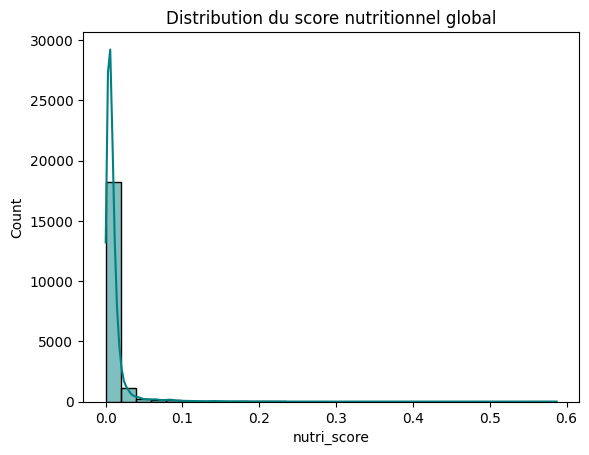

In [24]:
from sklearn.preprocessing import MinMaxScaler

cols = ["calories","fat","sugar","sodium","protein","sat_fat","carbs"]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_nutrition[cols]), columns=cols)

df_nutrition["nutri_score"] = (
    df_scaled["calories"]*0.3 +
    df_scaled["sugar"]*0.25 +
    df_scaled["fat"]*0.2 +
    df_scaled["sodium"]*0.15 -
    df_scaled["protein"]*0.1
)
sns.histplot(df_nutrition["nutri_score"], bins=30, kde=True, color="teal")
plt.title("Distribution du score nutritionnel global")
plt.show()


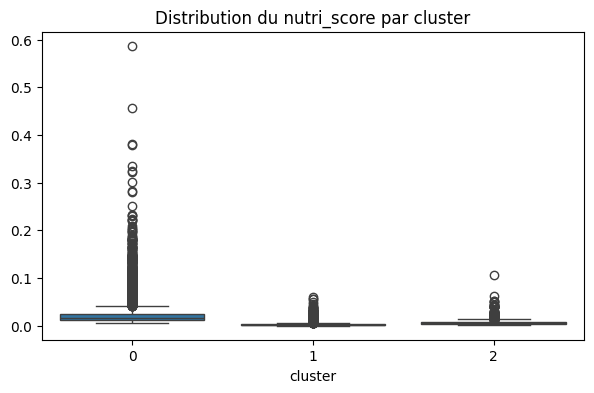

In [25]:
# nutri score par clusters
if "nutri_score" in df_nutrition.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df_work, x="cluster", y=df_nutrition.loc[X_index, "nutri_score"].values)
    plt.title("Distribution du nutri_score par cluster")
    plt.show()


In [26]:
# top ingrédients par cluster
if "ingredients" in df_nutrition.columns:
    text = df_nutrition.loc[X_index, "ingredients"].astype(str).str.lower().str.replace(r"[^a-zA-Z\s]", " ", regex=True)
    tfidf = TfidfVectorizer(max_features=3000, stop_words="english")
    M = tfidf.fit_transform(text)

    top_terms = {}
    for cid in sorted(df_work["cluster"].unique()):
        mask = df_work["cluster"]==cid
        # moyenne TF-IDF du cluster
        mean_vec = M[mask].mean(axis=0).A1
        top_idx = mean_vec.argsort()[::-1][:10]
        top_terms[cid] = [tfidf.get_feature_names_out()[i] for i in top_idx]
    top_terms


In [ ]:
import pandas as pd
import ast

df = pd.read_csv("../data/RAW_recipes.csv")

# extraction colonne nutrition contenant calories fat sugar sodium protein saturated fat carbs
df_nutri = pd.DataFrame(df["nutrition"].apply(ast.literal_eval).tolist(),
                        columns=["calories","fat","sugar","sodium","protein","sat_fat","carbs"])

# fusion id/name pour garder les infos principales
df_full = pd.concat([df[["id","name"]], df_nutri], axis=1)

# Création de 4 features

# feature #1 ca mesure la densité energetique : 
# c'est les calories par unités de macronutriments ( plus c'est haut plus la recette est riche , ca oscille entre 0.5 et 10)
df_full["energy_density"] = df_full["calories"] / (df_full["carbs"] + df_full["protein"] + df_full["fat"] + 1)

# feature # 2 proportion de prots par calorie :
# si c'est haut c'est protéiné , ca oscille entre 0.01 a 0.4
df_full["protein_ratio"] = df_full["protein"] / (df_full["calories"] + 1)

# feature #3  meme chose que protein-ratio pour les lipides , ca va de 0.0 a 0.6
df_full["fat_ratio"] = df_full["fat"] / (df_full["calories"] + 1)

# feature #4 un indice global pour mesurer l'equilibre nutritionnel du plat ( prot vs sucre gras calo sel):
# si c'est positif la recette est equilibré , et ca va de -0.3 a 0.05
df_full["nutrient_balance_index"] = (
    (df_full["protein"] - (df_full["fat"] + df_full["sugar"] + df_full["sodium"]) / 3)
    / (df_full["calories"] + 1)
)

# cleaning
df_export = df_full[["id", "name", "energy_density", "protein_ratio", "fat_ratio", "nutrient_balance_index"]]

df_export.to_csv("features_nutrition.csv", index=False, sep=";")

print("Fichier 'features_nutrition.csv' créé avec succès !")
print("Aperçu :")
print(df_export.head())


✅ Fichier 'features_nutrition.csv' créé avec succès !
Aperçu :
       id                                        name  energy_density  \
0  137739  arriba   baked winter squash mexican style        7.357143   
1   31490            a bit different  breakfast pizza        4.128571   
2  112140                   all in the kitchen  chili        4.026866   
3   59389                          alouette  potatoes        7.078846   
4   44061          amish  tomato ketchup  for canning       10.693939   

   protein_ratio  fat_ratio  nutrient_balance_index  
0       0.038095   0.000000               -0.044444  
1       0.126147   0.103211                0.059251  
2       0.144018   0.081241                0.018464  
3       0.037930   0.046058                0.011740  
4       0.008477   0.002826               -0.331544  


In [36]:
pd.read_csv("features_nutrition.csv").head()


,id,name,energy_density,protein_ratio,fat_ratio,nutrient_balance_index
0,137739,arriba baked winter squash mexican style,7.357143,0.038095,0.000000,-0.044444
1,31490,a bit different breakfast pizza,4.128571,0.126147,0.103211,0.059251
2,112140,all in the kitchen chili,4.026866,0.144018,0.081241,0.018464
3,59389,alouette potatoes,7.078846,0.037930,0.046058,0.011740
4,44061,amish tomato ketchup for canning,10.693939,0.008477,0.002826,-0.331544
